# An Introduction to the Immersed Boundary Method

In this notebook, we introduce + demonstrate a simple 2D immersed boundary method. We simulate the *fluid-structure interaction* for an elastic fiber immersed in an incompressible fluid. This closely follows the formalism outlined in Charles Peskin's Immersed Boundary Method course, and much of the underlying code is adapted from the IB-MATLAB implementation by Guanha Sun on Github. 

## The Fluid
In general, we can model a fluid via the incompressible Navier Stokes equations:

$ \rho(\partial_t + \vec{u}\cdot\vec{\nabla})\vec{u} = \mu\nabla^2 \vec{u} - \vec{\nabla} P + \rho\vec{f}$

$\vec{\nabla}\cdot\vec{u}=0$

with density $\rho$ and velocity $u$, viscosity $\mu$, pressure $P$, and where $f$ is an external force density. 

We can easily solve these equations with simple boundary conditions on a grid using any generic fluid solver.

## The Solid
NS are hard to solve for complex boundary conditions, so modeling the flow around a strangely shaped obstacle - especially a deformable obstacle - is difficult. This is where the Immersed Boundary Method comes in. 

We treat the boundary as a set of Lagrangian points $X$ which move at the fluid velocity $U$ (i.e. no-slip) and are connected by springs of stiffness $K$. Then, to model the fluid-structure interaction, the elastic force felt at each boundary point is then exerted locally onto the fluid. Since the only effect of the boundary on the fluid is to exert an external force, NS can be solved for a fluid without the geometry of the boundary. 

Crucially, the fluid $u$ is modeled on an *eulerian* grid, while the *lagrangian* boundary points $X$ are generally off-grid. A *discrete dirac-delta function* can be used to transform from the eulerian grid to the lagrangian boundary, and vice versa. In particular, to calculate the Lagrangian boundary velocity $U$ , we can *interpolate* the nearby Eulerian velocities $u$; and likewise, we can *spread* the elastic Lagrangian force $F$ onto the nearby eulerian gridpoints to exert a force density $f$. 

Here, we use the four-point dirac-delta function constructed by Peskin - which effectively means we interpolate to / spread from the nearest 4x4(x4) Eulerian points, with the appropriate weights. 

## Implementation

 The immersed boundary method generally proceeds as follows:

- At each timestep, we interpolate the local fluid velocity $u(t)$ to find the boundary velocity $U(t)$ and then estimate the new boundary position $X$


- The elastic force at the new boundary point $X_k$ is $F_k \approx K(X_{k+1}-X_k) + K(X_k-X_{k-1})$. At each boundary point, we spread this force to the fluid and then solve Navier Stokes with the resulting external force density $f$ to compute the new fluid velocity $u$


To properly model the time evolution of the system, we must calculate both the velocity of the fluid $u^{n+1}$ and the position of the immersed boundary $X^{n+1}$ at each timestep. Since the boundary motion is determined by the fluid velocity, and force exerted on the fluid is determined by the boundary position, calculating both of these simultaneously is tricky. Consequently, we *iterate* the system by first computing the boundary position at a *half* timestep $X^{n+1/2}$, and use the resulting 'midpoint' force $F^{n+1/2}$ to compute both the updated fluid velocity $u^{n+1}$, and the 'midpoint' fluid velocity $u^{n+1/2}$ used to compute the updated boundary position $X^{n+1}$. Explicitly,

- We first compute the *midpoint* boundary position  $XX = X(t+\frac{dt}{2} \approx X(t)+\frac{dt}{2}U(t)$, and then compute the force density $ff$ at the midpoint. 
- We then solve Navier Stokes subject to $ff$ to find both the updated fluid velocity $u(t+dt)$; and the midpoint fluid velocity $uu\equiv u(t+\frac{dt}{2})$
- Finally, we interpolate $uu$ to find the midpoint boundary velocity $UU \equiv U(t+\frac{dt}{2})$, and the updated boundary $X(t+dt) = X(t) + UUdt$


In [4]:
#### Script for IBM simulation of a single droplet in incompressible, periodic fluid
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec

%matplotlib notebook 


from fluid2 import FLUID    #### Generic fluid solver
from ib2 import IB2         #### 2D Immersed Boundary object (droplet membrane)
from util import *          #### General functions (iterate, geometry, force functions, etc)
import warnings; warnings.simplefilter('ignore')



In [5]:
# Fluid Parameters
L = 1.0                 # Domain Length
N = 64                 # Domain Points (NxN grid)
mu = 0.01               # viscosity
dt = 0.01             # timestep
nsteps = 5000            # simulation time 
nmod = 20               # save every nmod frames


RES=1                   # Adjust time resolution
dt/=RES
nsteps*=RES
nmod*=RES

# Immersed Body Parameters
K = 40
Nb = 100
rad = 0.05
positions = [[0.5, 0.5]]    
# rad = [0.05, 0.1]
# positions = [[0.2, 0.2], [0.6, 0.6]]

# The Fluid Solver: Poisseuille(-ish) Benchmark and Boundary Conditions

To model the incompressible fluid, we use a simple Fast Fourier Transform (FFT) solver which can efficiently solve NS with periodic BC's. Dirichlet and Neumann BC's can be implemented in a number of ways, including using more specialized even/odd Fourier Transforms or applying external forces at the boundaries. 

As a benchmark, we model a pressure-driven flow through a no-slip (dirichlet) channel. The driving flow is implemented as an applied force at the inlet, and dirichlet conditions are implemented via "ghost cells", i.e. imposing $u=0$ at the channel walls. Ghost cells are not technically appropriate in this scenario, but we will see that they do a decent (although imperfect) job.


<IPython.core.display.Javascript object>


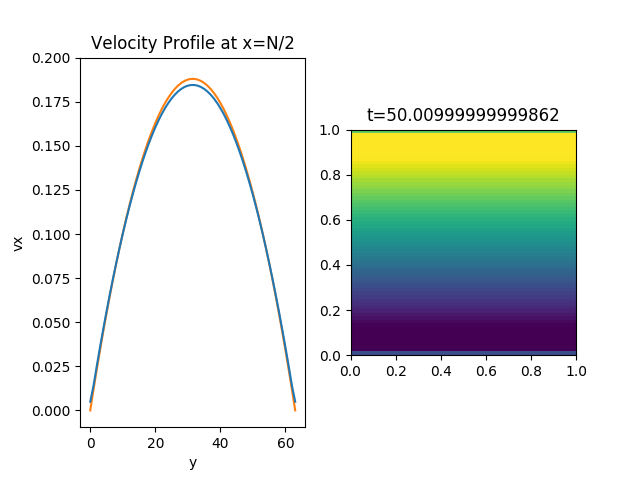

In [6]:
def channel(u):       ## No-slip channel
    u[0][:, 0] = 0.
    u[0][:,-1] = 0.

    u[1][:, 0] = 0.
    u[1][:,-1] = 0.
    
fluid = FLUID(N=N, L=L, mu=mu, dt=dt)
fluid.boundary = channel   
inlet_pressure = 0*fluid.u
inlet_pressure[0][0, :] = 1.    ## External force density is pressure-driven flow at inlet

fig = plt.figure()

# Velocity Profile
ax = fig.add_subplot(1,2,1)
ax.set_title('Velocity Profile at x=N/2')
ax.set_xlabel('y')
ax.set_ylabel('vx')

cmap = plt.get_cmap('tab10')
y = np.linspace(0, fluid.L, fluid.N)
u_theo = -.752*y*(y-fluid.L)
profile_theo = ax.plot(u_theo, color=cmap(1))

#### Vorticity Map
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim([0, fluid.L])
ax2.set_ylim([0, fluid.L])

ims = []
for i in range(nsteps+1):
    uu = fluid.step_u(inlet_pressure)
    if i%nmod==0:
        #Velocity Profile
        im = ax.plot(fluid.u[0][int(fluid.N/2), :], color=cmap(0))  ## ax.plot returns a list of 2DLines (e.g. list of artists)
        im.extend(profile_theo)

        # Vorticity Map
        im.append(show_vorticity(fluid.u, fluid.L, ax2))     #### show_vorticity returns output from plt.imshow(), which is an artist
        im.append(ax2.set_title('t={}'.format(1*fluid.t)))
        ims.append(im)

ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=100)
# ani.save(ani_path+'2D_pois_vanilla.gif', writer='pillow')
# u_pois = fluid.u

## Reynolds Number

In the specific case of flow through a pipe, the flow profile has the analytic form $v_x = \frac{Gy^2}{4\mu}$, where $y$ is the distance from the center of the pipe, and $G\equiv\Delta P/L$ is dependent on the pressure gradient.

Plugging in our boundary condition that the walls are moving at $u_0$ at a $y=L_y/2$, we have 

$u_0 = \frac{G(L/2)^2}{4\mu}$, and $v_x = u_0\big(\frac{2y}{L_y}\big)^2$

This allows us to quantify Reynolds number and the scale of the inlet flow $G$ in terms of system parameters.

# Immersed Bodies

Next, we add some elastic bodies. In particular, we add two circlular elastic membranes into the poisseuille-flow. This also illustrates the general workflow for these types of simulations:
Next, we illustrate a general procedure for modeling a system:

1) Initialize the fluid and fluid parameters (L, $\rho$, $\eta$, etc) and fields (i.e. $\vec{u}$)

2) Initialize the immersed boundary(ies) and specify relevant parameters (i.e. $K$)

3) Iterate the system in time


In [7]:
#### Iterate fluids and immersed solids using built-in functions
def iterate(fluid, solids):   
    ff = 0.          ## Force density on fluid
    for solid in solids:
#         solid.XX=solid.X+(dt/2)*solid.interp(fluid.u,solid.X)  # Euler step to midpoint
#         F = solid.Force(solid.XX)
#         ff += solid.vec_spread(F,solid.XX) # Force at midpoint # Force at midpoint 
        solid.step_XX(fluid.u)                                   # equivalent built-in functions
        ff += solid.ff 
    ff += inlet_pressure
    uu=fluid.step_u(ff) # Step Fluid Velocity
    for solid in solids:
#         solid.X+=dt*solid.interp(uu,solid.XX) # full step using midpoint velocity         
        solid.step_X(uu)                        # built-in function            
        
def CIRCLE(RAD=1., POS=(0.,0.), Nb=100):  
    theta = np.linspace(0, 2*np.pi, Nb+1)[:-1]
    return RAD*np.stack([np.cos(theta), np.sin(theta)], axis=1) + POS


####################################
  ########   Simulation   ########
####################################

RAD = [.2, .1]
POS = [[.1, .3], [.1, .8]]

solids = [IB2( CIRCLE(RAD[i], POS[i], Nb), fluid.N, fluid.h, fluid.dt) for i in range(2)]

#### Values that we're tracking
U = []
X = [[] for solid in solids]


# for i in range(nsteps+1):
for i in range(1001):
    iterate(fluid, solids)
    if i%nmod==0:
        print(i)
        U.append(fluid.u.copy())
        for j, solid in enumerate(solids): X[j].append(solid.X.copy())
           

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000


<IPython.core.display.Javascript object>


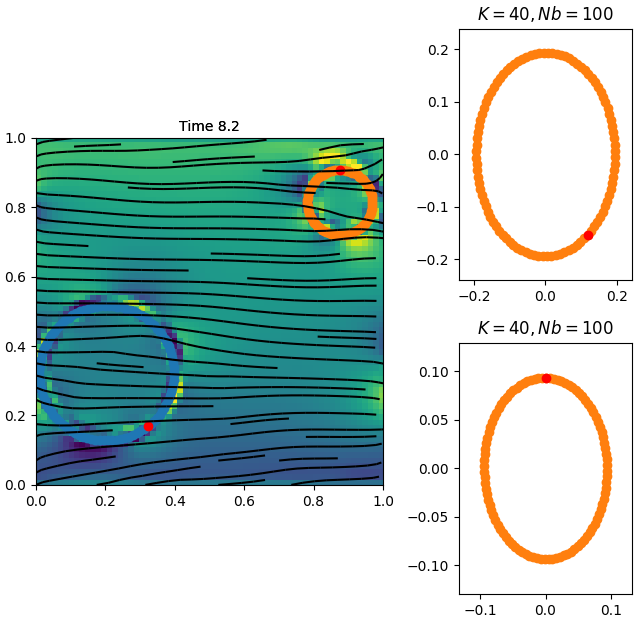

In [8]:
#### Animation
fig = plt.figure(constrained_layout=True)
nfigs = len(X)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, Nb={}$'.format(K, Nb))
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

for i, u in enumerate(U):
    im = [show_vorticity(u, L, ax)]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    for j, axj in enumerate(axes_frame):
        x = X[j][i]
        im.append(ax.scatter(x[:,0]%L, x[:,1]%L, color=cmap(j)))
        im.append(ax.scatter(x[0,0]%L, x[0,1]%L, color='Red'))
        im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))

        #### Plot in COM Frame
        x0 = x - np.mean(x, axis=0)
        im.append(axj.scatter(x0[:,0], x0[:,1], color=cmap(1)))
        im.append(axj.scatter([x0[0,0]], [x0[0,1]], color='red'))  ## Mark theta=0
    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')

In [9]:
ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)